# Plan house improvements using causal analysis

This notebook demonstrates the use of the Responsible AI Toolbox to make renovation decisions from historic apartments pricing data. It is based on a [similar notebook in the `responsible-ai-toolbox` repository](https://github.com/microsoft/responsible-ai-toolbox/blob/main/notebooks/responsibleaidashboard/responsibleaidashboard-housing-decision-making.ipynb), but updated to use the AzureML Responsible AI components.

First, we need to specify the version of the RAI components which are available in the workspace. This was specified when the components were uploaded, and will have defaulted to '1':

In [ ]:
version_string = "1"

We also need to give the name of the compute cluster we want to use in AzureML. Later in this notebook, we will create it if it does not already exist:

In [ ]:
compute_name = "rai-cluster"

Finally, we need to specify a version for the data and components we will create while running this notebook. This should be unique for the workspace, but the specific value doesn't matter:

In [ ]:
rai_house_improvement_version_string = "1"

## Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the MLClient from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace.

In [ ]:
# Enter details of your AML workspace
subscription_id = "<SUBSCRIPTION_ID>"
resource_group = "<RESOURCE_GROUP>"
workspace = "<AML_WORKSPACE_NAME>"

In [ ]:
# Handle to the workspace
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()
ml_client = MLClient(
    credential=credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace,
)
print(ml_client)

In [ ]:
# Get handle to azureml registry for the RAI built in components
registry_name = "azureml"
ml_client_registry = MLClient(
    credential=credential,
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    registry_name=registry_name,
)
print(ml_client_registry)

## Accessing the Data

We supply the synthetic data as a pair of parquet files and accompanying `MLTable` file. We can read them in and take a brief look:

### Fetching the data

In [ ]:
train_data_path = "data-housing-regression/train/"

In [ ]:
test_data_path = "data-housing-regression/test/"

Load some data for a quick view:

In [ ]:
import os
import pandas as pd
import mltable

tbl = mltable.load(train_data_path)
train_df: pd.DataFrame = tbl.to_pandas_dataframe()

# test dataset should have less than 5000 rows
test_df = mltable.load(test_data_path).to_pandas_dataframe()
assert len(test_df.index) <= 5000

display(train_df)

### Get the Data to AzureML

First, we need to upload the datasets to our workspace. 

In [ ]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

input_train_data = "housing_improvement_train_mltable"
input_test_data = "housing_improvement_test_mltable"

try:
    # Try getting data already registered in workspace
    train_data = ml_client.data.get(
        name=input_train_data, version=rai_house_improvement_version_string
    )
    test_data = ml_client.data.get(
        name=input_test_data, version=rai_house_improvement_version_string
    )
except Exception as e:
    train_data = Data(
        path=train_data_path,
        type=AssetTypes.MLTABLE,
        description="RAI housing improvement example training data",
        name=input_train_data,
        version=rai_house_improvement_version_string,
    )
    ml_client.data.create_or_update(train_data)

    test_data = Data(
        path=test_data_path,
        type=AssetTypes.MLTABLE,
        description="RAI housing improvement example test data",
        name=input_test_data,
        version=rai_house_improvement_version_string,
    )
    ml_client.data.create_or_update(test_data)

## A model training pipeline

Firstly, we should note that for this example, we do not actually require a model; we are going to undertake a causal analysis which purely works on the data. However, for our Responsible AI components, a model is required, since the portal shows the analyses under the Model view. To simplify the model creation process, we're going to use a pipeline. This will have two stages:

1. The actual training component
1. A model registration component

We have to register the model in AzureML in order for our RAI insights components to use it.

### The Training Component

The training component is for this particular model. In this case, we are going to use the `DummyRegressor` from SciKit-Learn.

We start by creating a directory to hold the component source:

In [ ]:
import os

os.makedirs("component_src", exist_ok=True)
os.makedirs("register_model_src", exist_ok=True)

Now, the component source code itself:

In [ ]:
%%writefile component_src/dummy_regressor_script.py

import argparse
import os
import shutil
import tempfile


from azureml.core import Run

import mlflow
import mlflow.sklearn

import mltable

import pandas as pd
from sklearn.dummy import DummyRegressor

def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--training_data", type=str, help="Path to training data")
    parser.add_argument("--target_column_name", type=str, help="Name of target column")
    parser.add_argument("--model_output", type=str, help="Path of output model")

    # parse args
    args = parser.parse_args()

    # return args
    return args


def main(args):
    current_experiment = Run.get_context().experiment
    tracking_uri = current_experiment.workspace.get_mlflow_tracking_uri()
    print("tracking_uri: {0}".format(tracking_uri))
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(current_experiment.name)

    # Read in data
    print("Reading data")
    tbl = mltable.load(args.training_data)
    all_data = tbl.to_pandas_dataframe()

    print("Extracting X_train, y_train")
    print("all_data cols: {0}".format(all_data.columns))
    y_train = all_data[args.target_column_name]
    X_train = all_data.drop(labels=args.target_column_name, axis="columns")
    print("X_train cols: {0}".format(X_train.columns))

    print("Training model")
    # The estimator can be changed to suit
    model = DummyRegressor()
    model.fit(X_train, y_train)

    # Saving model with mlflow - leave this section unchanged
    with tempfile.TemporaryDirectory() as td:
        print("Saving model with MLFlow to temporary directory")
        tmp_output_dir = os.path.join(td, "my_model_dir")
        mlflow.sklearn.save_model(sk_model=model, path=tmp_output_dir)

        print("Copying MLFlow model to output path")
        for file_name in os.listdir(tmp_output_dir):
            print("  Copying: ", file_name)
            # As of Python 3.8, copytree will acquire dirs_exist_ok as
            # an option, removing the need for listdir
            shutil.copy2(src=os.path.join(tmp_output_dir, file_name), dst=os.path.join(args.model_output, file_name))


# run script
if __name__ == "__main__":
    # add space in logs
    print("*" * 60)
    print("\n\n")

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")

In [ ]:
%%writefile register_model_src/register.py

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------

import argparse
import json
import os
import time


from azureml.core import Run

import mlflow
import mlflow.sklearn

# Based on example:
# https://docs.microsoft.com/en-us/azure/machine-learning/how-to-train-cli
# which references
# https://github.com/Azure/azureml-examples/tree/main/cli/jobs/train/lightgbm/iris


def parse_args():
    # setup arg parser
    parser = argparse.ArgumentParser()

    # add arguments
    parser.add_argument("--model_input_path", type=str, help="Path to input model")
    parser.add_argument(
        "--model_info_output_path", type=str, help="Path to write model info JSON"
    )
    parser.add_argument(
        "--model_base_name", type=str, help="Name of the registered model"
    )
    parser.add_argument(
        "--model_name_suffix", type=int, help="Set negative to use epoch_secs"
    )

    # parse args
    args = parser.parse_args()

    # return args
    return args


def main(args):
    current_experiment = Run.get_context().experiment
    tracking_uri = current_experiment.workspace.get_mlflow_tracking_uri()
    print("tracking_uri: {0}".format(tracking_uri))
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(current_experiment.name)

    print("Loading model")
    mlflow_model = mlflow.sklearn.load_model(args.model_input_path)

    if args.model_name_suffix < 0:
        suffix = int(time.time())
    else:
        suffix = args.model_name_suffix
    registered_name = "{0}_{1}".format(args.model_base_name, suffix)
    print(f"Registering model as {registered_name}")

    print("Registering via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=mlflow_model,
        registered_model_name=registered_name,
        artifact_path=registered_name,
    )

    print("Writing JSON")
    dict = {"id": "{0}:1".format(registered_name)}
    output_path = os.path.join(args.model_info_output_path, "model_info.json")
    with open(output_path, "w") as of:
        json.dump(dict, fp=of)


# run script
if __name__ == "__main__":
    # add space in logs
    print("*" * 60)
    print("\n\n")

    # parse args
    args = parse_args()

    # run main function
    main(args)

    # add space in logs
    print("*" * 60)
    print("\n\n")


Now that the training script is saved on our local drive, we create a YAML file to describe it as a component to AzureML. This involves defining the inputs and outputs, specifing the AzureML environment which can run the script, and telling AzureML how to invoke the training script:

In [ ]:
from azure.ai.ml import load_component

yaml_contents = (
    f"""
$schema: http://azureml/sdk-2-0/CommandComponent.json
name: rai_dummy_training_component
display_name: Dummy Regressor component for RAI example
version: {rai_house_improvement_version_string}
type: command
inputs:
  training_data:
    type: path
  target_column_name:
    type: string
outputs:
  model_output:
    type: path
code: ./component_src/
environment: azureml://registries/azureml/environments/AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu/versions/4
"""
    + r"""
command: >-
  python dummy_regressor_script.py
  --training_data ${{{{inputs.training_data}}}}
  --target_column_name ${{{{inputs.target_column_name}}}}
  --model_output ${{{{outputs.model_output}}}}
"""
)

yaml_filename = "RAIDummyTrainingComponent.yaml"

with open(yaml_filename, "w") as f:
    f.write(yaml_contents.format(yaml_contents))

train_model_component = load_component(source=yaml_filename)

In [ ]:
yaml_contents = f"""
$schema: http://azureml/sdk-2-0/CommandComponent.json
name: register_model
display_name: Register Model
version: {rai_house_improvement_version_string}
type: command
is_deterministic: False
inputs:
  model_input_path:
    type: path
  model_base_name:
    type: string
  model_name_suffix: # Set negative to use epoch_secs
    type: integer
    default: -1
outputs:
  model_info_output_path:
    type: path
code: ./register_model_src/
environment: azureml://registries/azureml/environments/AzureML-responsibleai-0.20-ubuntu20.04-py38-cpu/versions/4
command: >-
  python register.py
  --model_input_path ${{{{inputs.model_input_path}}}}
  --model_base_name ${{{{inputs.model_base_name}}}}
  --model_name_suffix ${{{{inputs.model_name_suffix}}}}
  --model_info_output_path ${{{{outputs.model_info_output_path}}}}

"""

yaml_filename = "register.yaml"

with open(yaml_filename, "w") as f:
    f.write(yaml_contents)

register_component = load_component(source=yaml_filename)

### Running a training pipeline

The component to register the model is part of the suite of RAI components, so we do not have to define it here. As such, we are now ready to run the training pipeline itself.

First, we need to make sure we have a compute cluster available:

In [ ]:
from azure.ai.ml.entities import AmlCompute

all_compute_names = [x.name for x in ml_client.compute.list()]

if compute_name in all_compute_names:
    print(f"Found existing compute: {compute_name}")
else:
    my_compute = AmlCompute(
        name=compute_name,
        size="Standard_D2_v2",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=3600,
    )
    ml_client.compute.begin_create_or_update(my_compute)
    print("Initiated compute creation")

Next, we define the name under which we want to register the model:

In [ ]:
import time

model_name_suffix = int(time.time())
model_name = "rai_dummy_housing_model"

Next, we define the pipeline using objects from the AzureML SDKv2. As mentioned above, there are two component jobs: one to train the model, and one to register it:

In [ ]:
from azure.ai.ml import dsl, Input

target_feature = "SalePriceK"
categorical_features = []

housing_improvement_train_pq = Input(
    type="mltable",
    path=f"azureml:{input_train_data}:{rai_house_improvement_version_string}",
    mode="download",
)
housing_improvement_test_pq = Input(
    type="mltable",
    path=f"azureml:{input_test_data}:{rai_house_improvement_version_string}",
    mode="download",
)


@dsl.pipeline(
    compute=compute_name,
    description="Register Model for RAI Housing Improvement example",
    experiment_name=f"RAI_Housing_Improvement_Example_Model_Training_{model_name_suffix}",
)
def my_training_pipeline(target_column_name, training_data):
    trained_model = train_model_component(
        target_column_name=target_column_name, training_data=training_data
    )
    trained_model.set_limits(timeout=120)

    _ = register_component(
        model_input_path=trained_model.outputs.model_output,
        model_base_name=model_name,
        model_name_suffix=model_name_suffix,
    )

    return {}


model_registration_pipeline_job = my_training_pipeline(
    target_feature, housing_improvement_train_pq
)

With the pipeline definition created, we can submit it to AzureML. We define a helper function to do the submission, which waits for the submitted job to complete:

In [ ]:
from azure.ai.ml.entities import PipelineJob
from IPython.core.display import HTML
from IPython.display import display


def submit_and_wait(ml_client, pipeline_job) -> PipelineJob:
    created_job = ml_client.jobs.create_or_update(pipeline_job)
    assert created_job is not None

    print("Pipeline job can be accessed in the following URL:")
    display(HTML('<a href="{0}">{0}</a>'.format(created_job.studio_url)))

    while created_job.status not in [
        "Completed",
        "Failed",
        "Canceled",
        "NotResponding",
    ]:
        time.sleep(30)
        created_job = ml_client.jobs.get(created_job.name)
        print("Latest status : {0}".format(created_job.status))
    assert created_job.status == "Completed"
    return created_job


# This is the actual submission
training_job = submit_and_wait(ml_client, model_registration_pipeline_job)

##  Creating the RAI Insights

We have a registered model, and can now run a pipeline to create the RAI insights. First off, compute the name of the model we registered:

In [ ]:
expected_model_id = f"{model_name}_{model_name_suffix}:1"
azureml_model_id = f"azureml:{expected_model_id}"

Now, we create the RAI pipeline itself. There are four 'component stages' in this pipeline:

1. Construct an empty `RAIInsights` object
1. Run the RAI tool components
1. Gather the tool outputs into a single `RAIInsights` object

We start by loading the RAI component definitions for use in our pipeline:

In [ ]:
label = "latest"

rai_constructor_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_insight_constructor", label=label
)

# We get latest version and use the same version for all components
version = rai_constructor_component.version
print("The current version of RAI built-in components is: " + version)

rai_causal_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_causal", version=version
)

rai_gather_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_insight_gather", version=version
)

rai_scorecard_component = ml_client_registry.components.get(
    name="microsoft_azureml_rai_tabular_score_card", version=version
)

## Score card generation config
For score card generation, we need some additional configuration in a separate json file. Here we configure the following model performance metrics for reporting:
- accuracy
- precision

In [ ]:
import json

score_card_config_dict = {
    "Model": {
        "ModelName": "Housing decision",
        "ModelType": "Regression",
        "ModelSummary": "<model summary>",
    },
    "Metrics": {"accuracy_score": {"threshold": ">=0.7"}, "precision_score": {}},
}

score_card_config_filename = "rai_housing_decision_score_card_config.json"

with open(score_card_config_filename, "w") as f:
    json.dump(score_card_config_dict, f)

score_card_config_path = Input(
    type="uri_file", path=score_card_config_filename, mode="download"
)

Now the pipeline itself. This creates an empty `RAIInsights` object, adds the analyses, and then gathers everything into the final `RAIInsights` output:

In [ ]:
import json
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes

treatment_feature_names = json.dumps(
    ["OverallCond", "OverallQual", "Fireplaces", "GarageCars", "ScreenPorch"]
)


@dsl.pipeline(
    compute=compute_name,
    description="Example RAI computation on housing improvement data",
    experiment_name=f"RAI_Housing_Improvements_Example_RAIInsights_Computation_{model_name_suffix}",
)
def rai_housing_improvement_pipeline(
    target_column_name, train_data, test_data, score_card_config_path
):
    # Initiate the RAIInsights
    create_rai_job = rai_constructor_component(
        title="RAI Dashboard Example",
        task_type="regression",
        model_info=expected_model_id,
        model_input=Input(type=AssetTypes.MLFLOW_MODEL, path=azureml_model_id),
        train_dataset=train_data,
        test_dataset=test_data,
        target_column_name=target_column_name,
        categorical_column_names=json.dumps(categorical_features),
    )
    create_rai_job.set_limits(timeout=120)

    # Add causal analysis
    causal_job = rai_causal_component(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        treatment_features=treatment_feature_names,
    )
    causal_job.set_limits(timeout=120)

    # Combine everything
    rai_gather_job = rai_gather_component(
        constructor=create_rai_job.outputs.rai_insights_dashboard,
        insight_1=causal_job.outputs.causal,
    )
    rai_gather_job.set_limits(timeout=120)

    rai_gather_job.outputs.dashboard.mode = "upload"
    rai_gather_job.outputs.ux_json.mode = "upload"

    # Generate score card in pdf format for a summary report on model performance,
    # and observe distrbution of error between prediction vs ground truth.
    rai_scorecard_job = rai_scorecard_component(
        dashboard=rai_gather_job.outputs.dashboard,
        pdf_generation_config=score_card_config_path,
    )

    return {
        "dashboard": rai_gather_job.outputs.dashboard,
        "ux_json": rai_gather_job.outputs.ux_json,
        "scorecard": rai_scorecard_job.outputs.scorecard,
    }

With all of our jobs defined, we can assemble them into the pipeline itself.

In [ ]:
import uuid
from azure.ai.ml import Output

# Pipeline to construct the RAI Insights
insights_pipeline_job = rai_housing_improvement_pipeline(
    target_column_name=target_feature,
    train_data=housing_improvement_train_pq,
    test_data=housing_improvement_test_pq,
    score_card_config_path=score_card_config_path,
)

# Workaround to enable the download
rand_path = str(uuid.uuid4())
insights_pipeline_job.outputs.dashboard = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/dashboard/",
    mode="upload",
    type="uri_folder",
)
insights_pipeline_job.outputs.ux_json = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/ux_json/",
    mode="upload",
    type="uri_folder",
)
insights_pipeline_job.outputs.scorecard = Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{rand_path}/scorecard/",
    mode="upload",
    type="uri_folder",
)

Now, submit the pipeline job and wait for it to complete:

In [ ]:
insights_job = submit_and_wait(ml_client, insights_pipeline_job)

The dashboard should appear on the Model Details page of the AzureML portal. The following cell computes the appropriate link:

In [ ]:
sub_id = ml_client._operation_scope.subscription_id
rg_name = ml_client._operation_scope.resource_group_name
ws_name = ml_client.workspace_name

expected_uri = f"https://ml.azure.com/model/{expected_model_id}/model_analysis?wsid=/subscriptions/{sub_id}/resourcegroups/{rg_name}/workspaces/{ws_name}"

print(f"Please visit {expected_uri} to see your analysis")

## Downloading the Scorecard PDF

We can download the scorecard PDF from our pipeline as follows:

In [ ]:
target_directory = "."

ml_client.jobs.download(
    insights_job.name, download_path=target_directory, output_name="scorecard"
)

Following the link should bring you to a page which looks similar to:
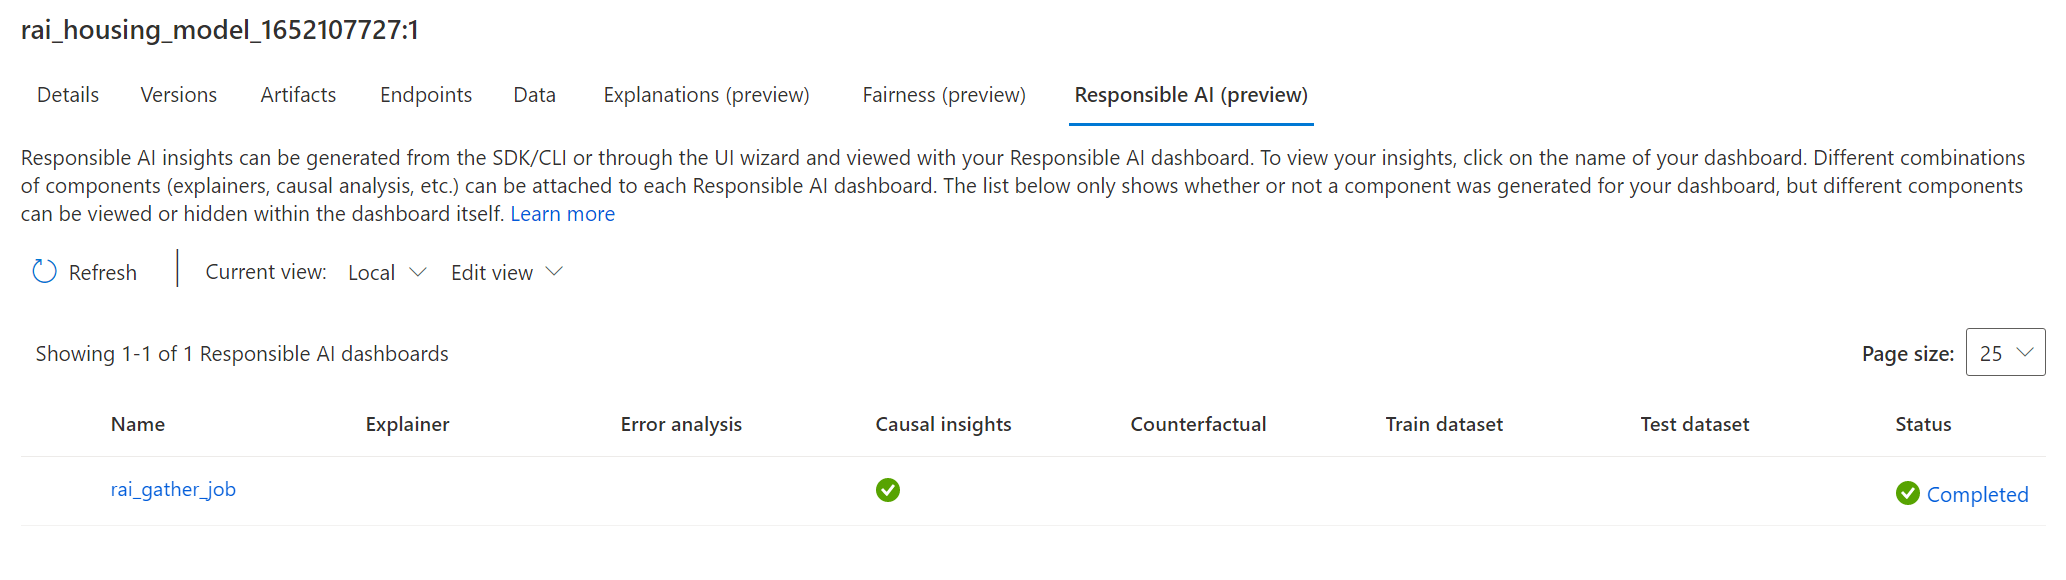

See this [developer blog](http://aka.ms/raidashboardblog) (Decision Making Flow section) to learn more about this use case and how to use the dashboard to identify value-adding home improvements.